# AI-Driven Customer Churn Prediction & Segmentation

## Phase 2 — Predictive Modeling

**Goal:** Build a baseline churn prediction model using logistic regression to identify customers at high risk of churn and evaluate model performance using business-relevant metrics.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

# Load
df = pd.read_csv("../data/raw/telco_churn.csv")

# Clean
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).copy()
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df.shape, df["Churn"].mean()


((7032, 21), np.float64(0.26578498293515357))

In [2]:
import os
os.getcwd()
os.listdir("../data/raw")


['.ipynb_checkpoints', 'telco_churn.csv']

In [3]:
df.shape, df["Churn"].mean()


((7032, 21), np.float64(0.26578498293515357))

In [4]:
# Define target (what we want to predict)
y = df["Churn"]

# Define features (remove target + ID column)
X = df.drop(columns=["Churn", "customerID"])

# Check
X.shape, y.value_counts(normalize=True)


((7032, 19),
 Churn
 0    0.734215
 1    0.265785
 Name: proportion, dtype: float64)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((5625, 19),
 (1407, 19),
 np.float64(0.2657777777777778),
 np.float64(0.2658137882018479))

In [6]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_features, categorical_features


(Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'),
 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'))

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

preprocess


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]
)

model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [9]:
model


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

# y_pred = predicted class (0/1)
# y_proba = predicted probability of churn (class=1), used for ROC-AUC and threshold tuning

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Confusion matrix gives counts of:
# [ [TN, FP],
#   [FN, TP] ]
# TN: correctly predicted non-churn
# FP: predicted churn but actually not
# FN: missed churn (dangerous for retention use-cases)
# TP: correctly predicted churn
confusion_matrix(y_test, y_pred)


array([[723, 310],
       [ 76, 298]])

In [11]:
# Classification report
# Shows precision/recall/F1 for each class:
# - Class 0 = non-churn
# - Class 1 = churn
print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.905     0.700     0.789      1033
           1      0.490     0.797     0.607       374

    accuracy                          0.726      1407
   macro avg      0.698     0.748     0.698      1407
weighted avg      0.795     0.726     0.741      1407



In [12]:
# ROC-AUC
# ROC-AUC measures how well the model ranks churners above non-churners
# (independent of a specific classification threshold like 0.5).
# 0.5 = random guessing, 1.0 = perfect ranking
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.3f}")


ROC-AUC: 0.835


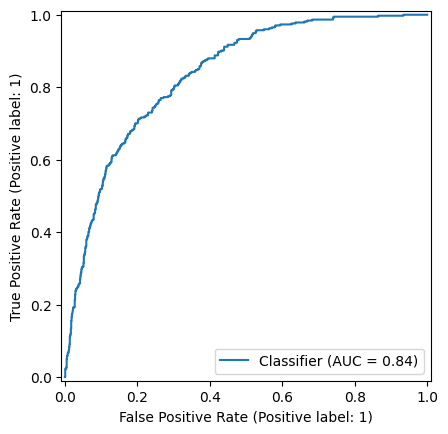

In [13]:
# ROC Curve visualization
# Shows trade-off between:
# - True Positive Rate (Recall) vs
# - False Positive Rate
# Helps assess model quality and compare models later

RocCurveDisplay.from_predictions(y_test, y_proba)


## Model Performance (Baseline — Logistic Regression)

- **ROC-AUC:** 0.835, indicating good overall ranking ability between churn and non-churn customers.
- **Churn recall (Class 1):** 0.797 — the model identifies ~80% of churners, which is valuable for retention targeting.
- **Churn precision (Class 1):** 0.490 — about half of flagged churners actually churn, meaning the model generates false positives.

**Business takeaway:** The baseline model is suitable for retention use-cases where missing churners is costly, but threshold tuning can reduce false positives depending on outreach cost and capacity.


In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
# List of probability cutoffs to evaluate
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
    # Convert churn probabilities into binary predictions using threshold t
    y_pred_t = (y_proba >= t).astype(int)
    # Measure how many predicted churners are actually churners
    p = precision_score(y_test, y_pred_t)
    # Measure how many actual churners are correctly identified
    r = recall_score(y_test, y_pred_t)
    # Display precision–recall trade-off for this threshold
    print(f"threshold={t:.1f}  precision={p:.3f}  recall={r:.3f}")


threshold=0.3  precision=0.415  recall=0.930
threshold=0.4  precision=0.452  recall=0.872
threshold=0.5  precision=0.490  recall=0.797
threshold=0.6  precision=0.541  recall=0.717
threshold=0.7  precision=0.611  recall=0.618


In [18]:
# Step 8 — Tune the decision threshold
# Goal: see how precision vs recall changes when we change the churn cutoff

from sklearn.metrics import precision_score, recall_score

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
    # Convert churn probabilities into 0/1 predictions using threshold t
    y_pred_t = (y_proba >= t).astype(int)
    
    # Precision: among flagged churners, how many truly churn?
    precision = precision_score(y_test, y_pred_t)
    
    # Recall: among true churners, how many did we catch?
    recall = recall_score(y_test, y_pred_t)
    
    print(f"threshold={t:.1f} | precision={precision:.3f} | recall={recall:.3f}")


threshold=0.3 | precision=0.415 | recall=0.930
threshold=0.4 | precision=0.452 | recall=0.872
threshold=0.5 | precision=0.490 | recall=0.797
threshold=0.6 | precision=0.541 | recall=0.717
threshold=0.7 | precision=0.611 | recall=0.618


## Decision Threshold Tuning

Because churn is only ~26.6% of customers, the default 0.5 threshold may not align with business goals.  
I evaluated multiple probability thresholds to analyze the precision–recall trade-off.

- At **threshold = 0.4**, **recall = 0.872** and **precision = 0.452**, which is suitable for retention scenarios where missing churners is costly and outreach is relatively low-cost.
- Higher thresholds increase precision but reduce recall, meaning more churners are missed.

**Selected operating threshold:** 0.4 (retention-focused).


In [19]:
# Apply chosen threshold (retention-focused)
chosen_threshold = 0.4
y_pred_04 = (y_proba >= chosen_threshold).astype(int)

print("Confusion Matrix (threshold=0.4):\n", confusion_matrix(y_test, y_pred_04))
print("\nClassification Report (threshold=0.4):\n", classification_report(y_test, y_pred_04, digits=3))


Confusion Matrix (threshold=0.4):
 [[638 395]
 [ 48 326]]

Classification Report (threshold=0.4):
               precision    recall  f1-score   support

           0      0.930     0.618     0.742      1033
           1      0.452     0.872     0.595       374

    accuracy                          0.685      1407
   macro avg      0.691     0.745     0.669      1407
weighted avg      0.803     0.685     0.703      1407



## Threshold Decision (0.4)

Lowering the decision threshold from 0.5 to 0.4 increased **churn recall** from ~0.80 to **0.872**, reducing missed churners (FN) from 76 to 48.  
This comes with more false positives (FP increased from 310 to 395), which is acceptable for retention use-cases where outreach is low-cost and the priority is minimizing missed churners.


In [14]:
# Extract top features from Logistic Regression (directional drivers)
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = np.r_[numeric_features, cat_feature_names]
coefs = model.named_steps["clf"].coef_[0]

coef_table = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
      .sort_values("coef", ascending=False)
)

# Top factors increasing churn probability
coef_table.head(15)


,feature,coef
36,Contract_Month-to-month,0.696066
16,InternetService_Fiber optic,0.660906
3,TotalCharges,0.607433
32,StreamingTV_Yes,0.252081
35,StreamingMovies_Yes,0.244732
43,PaymentMethod_Electronic check,0.229096
18,OnlineSecurity_No,0.199371
27,TechSupport_No,0.176853
14,MultipleLines_Yes,0.122750
26,DeviceProtection_Yes,0.083315


## Top Churn Drivers (Logistic Regression)

The baseline model suggests the strongest churn-risk signals are:
- **Month-to-month contract** (highest positive coefficient): customers without long-term commitment are most likely to churn.
- **Fiber optic internet service:** higher churn risk, potentially related to pricing or service experience.
- **Higher spending signals (e.g., TotalCharges):** associated with higher churn risk (direction considers standardized scaling).

Additional churn-associated factors include streaming add-ons, electronic check payments, and lack of security/support services.

### Business recommendations (based on drivers)
- **Contract strategy:** Incentivize month-to-month customers to move to 1-year / 2-year plans (discounts, loyalty perks).
- **Fiber retention:** Investigate fiber customer experience (pricing, reliability, support) and target proactive outreach for fiber customers.
- **Value/bundling:** Review pricing and value perception for streaming add-ons; test bundles or targeted offers.
- **Service add-ons:** Promote security/support add-ons as retention levers, especially for high-risk segments.
- **Payment method:** Encourage auto-pay methods to reduce churn risk (e.g., paperless + card/bank autopay incentives).


In [15]:
# Customers flagged as high churn risk at threshold=0.4
flagged = X_test.copy()
flagged["churn_proba"] = y_proba
flagged["pred_churn_04"] = (y_proba >= 0.4).astype(int)

flagged[flagged["pred_churn_04"] == 1].head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_proba,pred_churn_04
619,Female,0,No,No,7,Yes,Yes,Fiber optic,No,Yes,...,No,No,No,Month-to-month,Yes,Bank transfer (automatic),78.55,522.95,0.785655,1
3721,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.65,38.70,0.401375,1
445,Female,0,No,No,60,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,105.90,6396.45,0.722426,1
1346,Female,0,Yes,Yes,14,Yes,Yes,Fiber optic,No,No,...,No,No,Yes,Month-to-month,Yes,Electronic check,87.25,1258.60,0.845795,1
4283,Male,1,Yes,No,4,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.20,280.35,0.864224,1


## Example: High-Risk Customers (Threshold = 0.4)

To make the model actionable, I generated a “high-risk” list using the chosen threshold (0.4).  
The flagged customers commonly exhibit risk patterns consistent with the model drivers (e.g., **month-to-month contracts**, **fiber service**, **lack of security/support add-ons**, and **electronic check payments**), which supports the interpretability and usefulness of the baseline model for retention targeting.


In [16]:
# Re-attach customerID for an actionable retention list
high_risk = df.loc[X_test.index, ["customerID"]].copy()
high_risk["churn_proba"] = y_proba
high_risk["pred_churn_04"] = (y_proba >= 0.4).astype(int)

high_risk = high_risk[high_risk["pred_churn_04"] == 1].sort_values("churn_proba", ascending=False)
high_risk.head(10)


,customerID,churn_proba,pred_churn_04
3159,5150-ITWWB,0.934467,1
3380,5178-LMXOP,0.933984,1
2631,6861-XWTWQ,0.924494,1
4585,1069-XAIEM,0.922343,1
2797,6023-YEBUP,0.918260,1
3727,9057-SIHCH,0.918046,1
582,2865-TCHJW,0.917972,1
933,4750-ZRXIU,0.917168,1
2516,8245-UMPYT,0.909510,1
5213,7668-XCFYV,0.909267,1


## Phase 2 — Summary & Conclusions

A baseline churn prediction model was built using logistic regression with proper preprocessing for numerical and categorical features.  
The model achieved a **ROC-AUC of ~0.835**, indicating good ability to distinguish churners from non-churners.

Given the business objective of minimizing missed churners, the decision threshold was tuned from 0.5 to **0.4**, increasing **churn recall to ~87%** at the cost of additional false positives. This trade-off is suitable for retention use-cases where outreach is relatively low-cost.

Key churn drivers identified by the model align with exploratory analysis, including **month-to-month contracts**, **fiber optic internet service**, **higher spending signals**, and lack of **security/support add-ons**.  
The model also enables the creation of an actionable **high-risk customer list** to support targeted retention strategies.

These results provide a strong, interpretable baseline and inform the next phase: **customer segmentation and persona-driven retention strategies**.


## Phase 2 — Final Scoring & Export for Phase 3

This section regenerates the final churn scores for all customers
and saves the output dataset used in Phase 3 (Customer Segmentation).


In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# --- Start from your current raw df ---
df_model = df.copy()

# Clean TotalCharges (Telco dataset often has blanks as strings)
df_model["TotalCharges"] = pd.to_numeric(df_model["TotalCharges"], errors="coerce")

# Target: make sure it's 0/1
# If yours is already 0/1, this will keep it correct.
df_model["Churn"] = df_model["Churn"].replace({"Yes": 1, "No": 0})

# Drop rows where TotalCharges became NaN (usually tenure=0 customers)
df_model = df_model.dropna(subset=["TotalCharges"]).copy()

# Separate target + features
y = df_model["Churn"].astype(int)
X = df_model.drop(columns=["Churn"])

# Drop ID column if present (not a predictive feature)
if "customerID" in X.columns:
    X = X.drop(columns=["customerID"])

# Identify numeric vs categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocess: scale numeric, one-hot encode categorical
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Logistic Regression pipeline
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

# Train (you can keep this split just for fitting a reasonable baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

# Score ALL customers (this is what Phase 3 needs)
churn_proba = model.predict_proba(X)[:, 1]

df_scored = df_model.copy()
df_scored["churn_proba"] = churn_proba
df_scored["pred_churn_04"] = (df_scored["churn_proba"] >= 0.40).astype(int)

df_scored.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_proba,pred_churn_04
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0.622651,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0.044294,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0.286630,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0.028434,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0.690068,1


In [23]:
"churn_proba" in df_scored.columns, "pred_churn_04" in df_scored.columns


(True, True)

In [27]:
df_scored.to_csv("../data/processed/scored_customers.csv", index=False)
print("Saved: data/processed/scored_customers.csv")



Saved: data/processed/scored_customers.csv
